##QOSF Quantum Computing Mentorship Program Screening Task #4

This notebook has been prepared as a response to the fourth task of the screening task fo the [Quantum Computing Mentorship Program](https://qosf.org/qc_mentorship). It is based on Davit Khachatryan's [tutorial](https://github.com/DavitKhach/quantum-algorithms-tutorials/blob/master/variational_quantum_eigensolver.ipynb).

####Task Description

*Following has been copied directly from the task statement:*

>Find the lowest eigenvalue of the following matrix:
>
>[1 0 0 0; 0 0 -1 0; 0 -1 0 0; 0 0 0 1]
>
>using VQE-like circuits, created by yourself from scratch.


#### Imports
Before starting the main content, import Python libraries that will be used throughout this notebook.

In [1]:
# Install qiskit on Colaboratory
!pip install -q qiskit

In [2]:
import numpy
from qiskit import *
from qiskit.circuit.library.standard_gates import U2Gate
import matplotlib.pyplot as plt

#### Two Qubit Operators

Because the target Hamiltonian is defined for two-qubit system, it makes sense to calculate the two qubit operators before attempting to decompose the target Hamiltonian.

First, start with single qubit operators which are defined as following:

\begin{align}
I &= \begin{bmatrix}1 & 0 \\
                    0 & 1 \end{bmatrix}\\\
X &= \begin{bmatrix}0 & 1 \\
                    1 & 0 \end{bmatrix}\\\
Y &= \begin{bmatrix}0 & -i \\
                    i & 0 \end{bmatrix}\\\
Z &= \begin{bmatrix}1 & 0 \\
                    0 & -1 \end{bmatrix}
\end{align}

In order to construct two-qubit versions of these gates $II, XX, YY, ZZ$, tensor multiplications need to be performed.

\begin{align}
II &= I \otimes I \\
   &= \begin{bmatrix}
      1 \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} &
      0 \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} \\
      0 \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} &
      1 \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}
      \end{bmatrix} \\
   &= \begin{bmatrix}
      1 & 0 & 0 & 0 \\
      0 & 1 & 0 & 0 \\
      0 & 0 & 1 & 0 \\
      0 & 0 & 0 & 1
      \end{bmatrix}
\\
XX &= X \otimes X \\
   &= \begin{bmatrix}
      0 \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix} &
      1 \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix} \\
      1 \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix} &
      0 \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix}
      \end{bmatrix} \\
   &= \begin{bmatrix}
      0 & 0 & 0 & 1 \\
      0 & 0 & 1 & 0 \\
      0 & 1 & 0 & 0 \\
      1 & 0 & 0 & 0
      \end{bmatrix}
\\
YY &= Y \otimes Y \\
   &= \begin{bmatrix}
      0 \begin{bmatrix} 0 & -i \\ i & 0 \end{bmatrix} &
      -i\begin{bmatrix} 0 & -i \\ i & 0 \end{bmatrix} \\
      i \begin{bmatrix} 0 & -i \\ i & 0 \end{bmatrix} &
      0 \begin{bmatrix} 0 & -i \\ i & 0 \end{bmatrix}
      \end{bmatrix} \\
   &= \begin{bmatrix}
      0 & 0 & 0 & -1 \\
      0 & 0 & 1 & 0 \\
      0 & 1 & 0 & 0 \\
      -1 & 0 & 0 & 0
      \end{bmatrix}
\\
ZZ &= Z \otimes Z \\
   &= \begin{bmatrix}
      1 \begin{bmatrix} 1 & 0 \\ 0 & -1 \end{bmatrix} &
      0 \begin{bmatrix} 1 & 0 \\ 0 & -1 \end{bmatrix} \\
      0 \begin{bmatrix} 1 & 0 \\ 0 & -1 \end{bmatrix} &
      -1\begin{bmatrix} 1 & 0 \\ 0 & -1 \end{bmatrix}
      \end{bmatrix} \\
   &= \begin{bmatrix}
      1 & 0 & 0 & 0 \\
      0 & -1 & 0 & 0 \\
      0 & 0 & -1 & 0 \\
      0 & 0 & 0 & 1
      \end{bmatrix}
\end{align}

In [3]:
# Declare one-qubit gates
identity = numpy.identity(2)
x = numpy.array([[0, 1],[1, 0]])
y = numpy.array([[0, 0+-1j], [0+1j, 0]], dtype=complex)
z = numpy.array([[1, 0],[0, -1]])

# Two qubit version of the gates
II = numpy.kron(identity, identity)
XX = numpy.kron(x, x)
YY = numpy.real(numpy.kron(y, y))
ZZ = numpy.kron(z, z)

#### Decomposing Hamiltonian Matrix

Based on the two-qubit operators that were determined above, it is fairly straightforward to use these to decompose the Hamiltonian matrix. First note that the given Hamiltonian matrix $\mathcal{H}$ is expressed as:

\begin{align}
\mathcal{H} &= \begin{bmatrix}1 & 0 & 0 & 0\\
                              0 & 0 & -1 & 0\\
                              0 & -1 & 0 & 0\\
                              0 & 0 & 0 & 1 \end{bmatrix}
\end{align}

Because we know from the hint that the coefficients $c$ assigned to the decomposed form is among $\{-1, -\frac{1}{2}, 0, \frac{1}{2}, 1\}$, the decomposition is fairly simple and is equivalent to merely solving system of linear equations.

From $\mathcal{H}_{11}$, $c_{II}+c_{ZZ}=\mathcal{H}_{11}=1$ \\
From $\mathcal{H}_{14}$, $c_{XX}-c_{YY}=\mathcal{H}_{14}=0$ \\
From $\mathcal{H}_{22}$, $c_{II}-c_{ZZ}=\mathcal{H}_{22}=0$ \\
From $\mathcal{H}_{23}$, $c_{XX}+c_{YY}=\mathcal{H}_{23}=-1$

Solving the system of linear equations, solution of $\{c_{II}, c_{XX}, c_{YY}, c_{ZZ}\} = \{\frac{1}{2}, -\frac{1}{2}, -\frac{1}{2}, \frac{1}{2}\}$ is obtained. Therefore, this is the decomposed form of the given Hamiltonian:

\begin{align}
\mathcal{H} = \frac{1}{2} I_1 \otimes I_2 - \frac{1}{2} X_1 \otimes X_2 - \frac{1}{2} Y_1 \otimes\ Y_2 + \frac{1}{2} Z_1 \otimes Z_2
\end{align}


In [4]:
# Declare given Hamiltonian
hamil = numpy.array([[1, 0, 0, 0],[0, 0, -1, 0],[0, -1, 0, 0],[0, 0, 0, 1]])

#### Expectation Value of Two-qubit Operators

Now, let's evaluate the expectation values of the two-qubit operators used in the decomposed form in respect to a general wavefunction:
\begin{align}
\psi &= \begin{bmatrix}a \\ b \\ c \\ d \end{bmatrix}
\end{align}

For $I_1 \otimes I_2$, \\
\begin{align}
\left< \psi | I_1 \otimes I_2 | \psi \right> = 1
\end{align}
We see here that contribution from $I_1 \otimes I_2$ component is constant.

For $Z_1 \otimes Z_2$, using the fact that $Z\left| 0 \right> = +1 \left| 0 \right>$ and $Z\left| 1 \right> = -1 \left| 1 \right>$, \\
\begin{align}
\left< \psi | Z_1 \otimes Z_2 | \psi \right> = a^2-b^2-c^2+d^2
\end{align}
We see here that contribution from $Z_1 \otimes Z_2$ is equal to $\frac{n_\left| 00 \right> - n_\left| 01 \right> - n_\left| 10 \right> + n_\left| 11 \right>}{N}$ where $N = \Sigma n$ for all possible states.

For $X_1 \otimes X_2$, using the fact that $H\left| + \right> = \left| 0 \right>$ and $H\left| - \right> = \left| 1 \right>$, \\
\begin{align}
\left< \psi | X_1 \otimes X_2 | \psi \right> &= \left< \psi | (H_1 \otimes H_2)^\dagger (Z_1 \otimes Z_2) (H_1 \otimes H_2) | \psi \right> \\
H &= \frac{1}{\sqrt{2}}\begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}
\end{align}
After adding two-qubit equivalent of Hadamard gate, we can measure in an identical manner as we did for $Z_1 \otimes Z_2$ contribution.

For $Y_1 \otimes Y_2$, using the fact that $G\left| +i \right> = \left| 0 \right>$ and $G\left| -i \right> = \left| 1 \right>$, \\
\begin{align}
\left< \psi | Y_1 \otimes Y_2 | \psi \right> &= \left< \psi | (G_1 \otimes G_2)^\dagger (Y_1 \otimes Y_2) (G_1 \otimes G_2) | \psi \right> \\
G &= \frac{1}{\sqrt{2}}\begin{bmatrix} 1 & -i \\ 1 & i \end{bmatrix}
\end{align}
After adding two-qubit equivalent of G gate, we can measure in an identical manner as we did for $Z_1 \otimes Z_2$ contribution.

In `Qiskit`, this is taken into account by using `U2Gate` object.

#### Ansatz

Now, from the hint, ansatz can be declared as a circuit in Qiskit. Note that the ansatz was:

\begin{align}
\left | \psi \right> = (R_x(\theta) \otimes I)CX(H \otimes I) \left | 00 \right>
\end{align}

In [5]:
# Put some value for theta for visualization
theta = numpy.zeros((1))

# Build up the circuit - quantum state
qr = QuantumRegister(2)
cr = ClassicalRegister(2)
circuit = QuantumCircuit(qr, cr)

circuit.h(circuit.qregs[0][0])
circuit.cx(circuit.qregs[0][0], circuit.qregs[0][1])
circuit.rx(theta, circuit.qregs[0][0])

circuit.barrier()
circuit.draw()

┌───┐     ┌────┐ ░ 
q0_0: ┤ H ├──■──┤ RX ├─░─
      └───┘┌─┴─┐└────┘ ░ 
q0_1: ─────┤ X ├───────░─
           └───┘       ░ 
c0: 2/═══════════════════

Let's make this as a function so that theta can be given as an input.

In [6]:
def ansatz(theta):
  """
  theta: angle passed on to R_x gate; float
  """
  qr = QuantumRegister(2)
  cr = ClassicalRegister(2)
  circuit = QuantumCircuit(qr, cr)

  circuit.h(circuit.qregs[0][0])
  circuit.cx(circuit.qregs[0][0], circuit.qregs[0][1])
  circuit.rx(theta, circuit.qregs[0][0])

  circuit.barrier()

  return circuit

#### Measurement of Circuits

Now, using the information on how $XX$ and $YY$ can be measured, implement how they must be measured to obtain the simulated expectation values.

In [7]:
def count_results(result, N):
  """
  Return the expectation number from the quantum circuit execution results
  result: qiskit.result.result.Result instance
  N:      total number of runs
  """
  sum = 0.0
  for key, val in result.get_counts().items():
    if key == '00' or key == '11':
      sum += val
    elif key == '10' or key == '01':
      sum -= val
  return sum / N

In [8]:
def vqe(theta, n, backend = None):
  """
  theta: angle passed on to R_x gate in ansatz -- this is the variational
         parameter; float
  n : number of iterations to run the quantum circuit
  backend: backend to use for calculation; if nothing is provided, it assumes 'qasm_simulator'.

  Given Hamiltonian is decomposed into:
    (II-XX-YY+ZZ)/2
  """
  if backend == None:
    backend = Aer.get_backend('qasm_simulator')
  energy = 0.0

  # II term: constant
  energy += 0.5

  # XX term: H gate on both qubits before measurement
  circuit = ansatz(theta)
  circuit.u2(0, numpy.pi, circuit.qregs[0])
  circuit.measure(circuit.qregs[0], circuit.cregs[0])

  result = execute(circuit, backend = backend, shots = n).result()
  energy -= 0.5 * count_results(result, n)

  ## YY term: G gate on both qubits before measurement
  circuit = ansatz(theta)
  circuit.u2(0, numpy.pi/2, circuit.qregs[0])
  circuit.measure(circuit.qregs[0], circuit.cregs[0])

  result = execute(circuit, backend = backend, shots = n).result()
  energy -= 0.5 * count_results(result, n)

  ## ZZ term
  circuit = ansatz(theta)
  circuit.measure(circuit.qregs[0], circuit.cregs[0])

  result = execute(circuit, backend = backend, shots = n).result()
  energy += 0.5 * count_results(result, n)

  # Return energy
  return energy

#### Running the Simulation

Now, run the simulation on a range of $\theta = [0, 2\pi]$. The energies will be stored to obtain the minimum value.

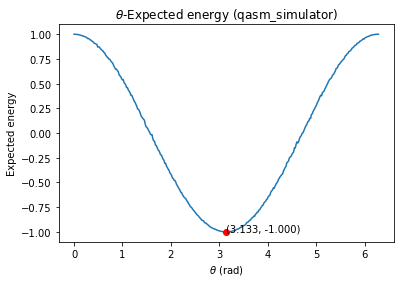

In [9]:
# Run simulation and store results
energy_list = []
theta_list = numpy.linspace(0.0, 2 * numpy.pi, 360)
for theta in theta_list:
  energy_list.append(vqe(theta, 1e4))

# Determine the minimum energy
energy_min = numpy.min(energy_list)
theta_min = theta_list[numpy.argmin(energy_list)]

# Generate a plot
plt.plot(theta_list, energy_list)
plt.title(r"$\theta$-Expected energy (qasm_simulator)")
plt.xlabel(r"$\theta$ (rad)")
plt.ylabel("Expected energy")
plt.plot(theta_min, energy_min, 'ro')
annot = "({:.3f}, {:.3f})".format(theta_min, energy_min)
plt.annotate(annot, (theta_min, energy_min))
plt.show()

The results match with what is expected from running `numpy.linalg.eigvals` function as below.

In [10]:
print("Smallest eigenvalue: {}".format(numpy.linalg.eigvals(hamil).min()))

Smallest eigenvalue: -1.0
